In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier # Importar clasificador de árbol de decisión
from sklearn.model_selection import train_test_split # Importar función train_test_split
from sklearn import metrics #Importar el módulo de métricas scikit-learn para calcular la precisión
from sklearn import tree #el arbol de decisión d
import matplotlib.pyplot as plt
from sklearn.tree import export_text
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action = 'ignore')
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
#Cargamos el DataFrame
pd.options.display.max_columns = 0
url = 'https://raw.githubusercontent.com/brunelboss/UB/main/crimedata.csv'
df = pd.read_csv(url, encoding='latin-1', na_values=["?"])
df.head(10)

,Êcommunityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.00,NaN,0,0.00,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.00,NaN,0,0.00,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.00,NaN,3,8.30,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.00,NaN,0,0.00,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.00,NaN,0,0.00,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79
5,Springfieldcity,MO,NaN,NaN,1,140494,2.45,2.51,95.65,0.90,0.95,18.09,32.89,20.04,13.26,140494,100.0,21577,75.78,1.00,41.15,29.31,7.12,14.09,27705,11878,12029,7382,10264,10753,7192.0,8104,23223,17.78,8.76,23.03,20.66,5.72,59.02,14.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.4,1995.7,0.97,NaN,NaN,NaN,NaN,0.00,NaN,7,4.63,77.0,50.98,136.0,90.05,449.0,297.29,2094.0,1386.46,7690.0,5091.64,454.0,300.60,134.0,88.72,442.95,6867.42
6,Norwoodtown,MA,21.0,50250.0,1,28700,2.60,1.60,96.57,1.47,1.10,11.17,27.41,12.76,14.42,28700,100.0,42805,79.47,0.39,47.70,30.23,5.41,17.23,50394,18193,18276,17342,21482,12639,21852.0,22594,1126,4.01,4.49,13.89,27.01,4.85,65.42,14.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9,2643.5,9.62,NaN,NaN,NaN,NaN,0.00,NaN,0,0.00,4.0,13.53,9.0,30.44,54.0,182.66,110.0,372.09,288.0,974.19,144.0,48

In [3]:
#Renombrar columna con caracter especial
df = df.rename(columns={'Êcommunityname':'communityName'})
df.head()

,communityName,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB


In [5]:
df.dtypes

communityName           object
state                   object
countyCode             float64
communityCode          float64
fold                     int64
                        ...   
autoTheftPerPop        float64
arsons                 float64
arsonsPerPop           float64
ViolentCrimesPerPop    float64
nonViolPerPop          float64
Length: 147, dtype: object

# Columnas "non-predictive"

In [6]:
#Seleccionar non-predictive, llamaremos a este dataframe df_NonPredictive

#df_np = df[['communityName', 'state', 'countyCode', 'communityCode', 'fold']]

df_NonPredictive = df.loc[:, 'communityName':'fold']

In [7]:
df_NonPredictive.head()

,communityName,state,countyCode,communityCode,fold
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1
1,Marpletownship,PA,45.0,47616.0,1
2,Tigardcity,OR,NaN,NaN,1
3,Gloversvillecity,NY,35.0,29443.0,1
4,Bemidjicity,MN,7.0,5068.0,1


In [8]:
# Contar porcentaje valores nulos por cada columna
df_aux = pd.DataFrame()
df_aux = df_NonPredictive.copy()
df_null = (df_aux.isna().sum()/df_aux.shape[0]).sort_values(ascending=False)
df_null.head()

communityCode    0.552596
countyCode       0.551242
communityName    0.000000
state            0.000000
fold             0.000000
dtype: float64

Existe un 55% de las columnas communityCode y countyCode del df_NonPredictive con valores NaN.

# Columnas Predictive

In [9]:
#Seleccionar Predictive, llamaremos a este dataframe df_Predictive

df_Predictive = df.loc[:, 'population':'PolicBudgPerPop']

In [10]:
df_Predictive.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,...,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,...,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,...,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,...,250,309,114,333,28.7,20.6,14.5,0,0,2.04,88.71,56.70,90.17,96.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN
4,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,36.54,10.94,27.80,7.51,50.66,...,283,362,160,332,32.2,23.2,12.9,2,0,1.74,73.75,42.22,60.34,89.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.0,NaN


In [11]:
# Contar porcentaje valores nulos por cada columna
df_aux = pd.DataFrame()
df_null = pd.DataFrame()
df_aux = df_Predictive.copy()
df_null = (df_aux.isna().sum()/df_aux.shape[0]).sort_values(ascending=False)
df_null.head(25)

PolicBudgPerPop         0.845147
PctPolicAsian           0.845147
LemasSwornFT            0.845147
LemasSwFTPerPop         0.845147
LemasSwFTFieldOps       0.845147
LemasSwFTFieldPerPop    0.845147
LemasTotalReq           0.845147
PolicReqPerOffic        0.845147
PolicPerPop             0.845147
RacialMatchCommPol      0.845147
PctPolicWhite           0.845147
PctPolicBlack           0.845147
PctPolicHisp            0.845147
LemasTotReqPerPop       0.845147
PctPolicMinor           0.845147
PolicCars               0.845147
OfficAssgnDrugUnits     0.845147
LemasGangUnitDeploy     0.845147
LemasPctPolicOnPatr     0.845147
PolicOperBudg           0.845147
PolicAveOTWorked        0.845147
NumKindsDrugsSeiz       0.845147
OtherPerCap             0.000451
OwnOccLowQuart          0.000000
PctWOFullPlumb          0.000000
dtype: float64

In [12]:
# Borrar columnas que tienen más de 50% de valores nulos
perc = 50.0
min_count =  int(((100-perc)/100)*df_Predictive.shape[0] + 1)
df_Predictive = df_Predictive.dropna( axis=1, 
                thresh=min_count)

In [13]:
df_aux = pd.DataFrame()
df_null = pd.DataFrame()
df_aux = df_Predictive.copy()
df_null = (df_aux.isna().sum()/df_aux.shape[0]).sort_values(ascending=False)
df_null.head()

OtherPerCap          0.000451
PersPerOwnOccHous    0.000000
PctVacMore6Mos       0.000000
PctVacantBoarded     0.000000
PctHousOwnOcc        0.000000
dtype: float64

(array([1.862e+03, 2.970e+02, 3.800e+01, 1.100e+01, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([     0.,  13700.,  27400.,  41100.,  54800.,  68500.,  82200.,
         95900., 109600., 123300., 137000.]),
 <a list of 10 Patch objects>)

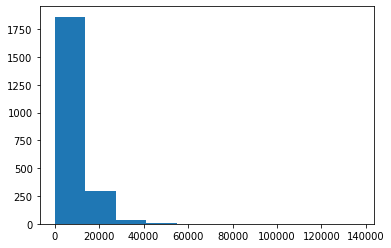

In [14]:
#Análisis OtherPerCap
#plt.boxplot(df_Predictive['OtherPerCap'], vert=False)
plt.hist(df_Predictive['OtherPerCap'])

In [15]:
df_Predictive['OtherPerCap'].describe()

count      2214.000000
mean       9442.765131
std        7926.466713
min           0.000000
25%        5528.250000
50%        8186.000000
75%       11525.500000
max      137000.000000
Name: OtherPerCap, dtype: float64

In [16]:
# reemplazar valores nulos por mediana
df_Predictive['OtherPerCap'] = df_Predictive['OtherPerCap'].fillna(df_Predictive['OtherPerCap'].median())

In [17]:
df_Predictive['OtherPerCap'].describe()

count      2215.000000
mean       9442.197743
std        7924.721423
min           0.000000
25%        5528.500000
50%        8186.000000
75%       11525.000000
max      137000.000000
Name: OtherPerCap, dtype: float64

In [18]:
df_aux = pd.DataFrame()
df_null = pd.DataFrame()
df_aux = df_Predictive.copy()
df_null = (df_aux.isna().sum()/df_aux.shape[0]).sort_values(ascending=False)
df_null.head()

population          0.0
PersPerOccupHous    0.0
PctVacantBoarded    0.0
PctHousOwnOcc       0.0
PctHousOccup        0.0
dtype: float64

# Columnas Potential Goal

In [19]:
#Seleccionar Potential Goal, llamaremos a este dataframe df_PotentialGoal

df_PotentialGoal = df.loc[:, 'murders':'nonViolPerPop']
df_PotentialGoal.head()

,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,0,0.0,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [20]:
# Contar porcentaje valores nulos por cada columna
df_aux = pd.DataFrame()
df_null = pd.DataFrame()
df_aux = df_PotentialGoal.copy()
df_null = (df_aux.isna().sum()/df_aux.shape[0]).sort_values(ascending=False)
df_null.head(25)

ViolentCrimesPerPop    0.099774
rapes                  0.093905
rapesPerPop            0.093905
nonViolPerPop          0.043792
arsonsPerPop           0.041084
arsons                 0.041084
assaults               0.005869
assaultPerPop          0.005869
larcPerPop             0.001354
autoTheftPerPop        0.001354
autoTheft              0.001354
burglPerPop            0.001354
larcenies              0.001354
burglaries             0.001354
robbbPerPop            0.000451
robberies              0.000451
murdPerPop             0.000000
murders                0.000000
dtype: float64

In [21]:
df_PotentialGoal[['ViolentCrimesPerPop', 'rapes', 'rapesPerPop']].describe()

,ViolentCrimesPerPop,rapes,rapesPerPop
count,1994.000000,2007.000000,2007.00000
mean,589.078922,28.046338,36.25848
std,614.784518,105.616135,34.23975
min,0.000000,0.000000,0.00000
25%,161.700000,2.000000,11.53500
50%,374.060000,7.000000,26.92000
75%,794.400000,19.000000,51.47000
max,4877.060000,2818.000000,401.35000


In [22]:
# reemplazar valores nulos por mediana
df_PotentialGoal = df_PotentialGoal.fillna(df_PotentialGoal.median())

In [23]:
df_PotentialGoal.head()

,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,5.0,21.08,306.64,4425.45
4,0,0.0,7.0,26.92,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,374.06,9988.79


# Análisis de los Datos

### **Modelo 1: Regresión Lineal con todas las variables disponibles para modelar**

In [24]:
print(df_NonPredictive.info(), end='\n\n')
print(df_Predictive.info(), end='\n\n')
print(df_PotentialGoal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   communityName  2215 non-null   object 
 1   state          2215 non-null   object 
 2   countyCode     994 non-null    float64
 3   communityCode  991 non-null    float64
 4   fold           2215 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 86.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 102 entries, population to LemasPctOfficDrugUn
dtypes: float64(75), int64(27)
memory usage: 1.7 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   murders              2215 non-null   int64  
 1   murdPerPop           2215 non-null   float64
 2   rapes            

In [25]:
X = df_Predictive
y = df_PotentialGoal['murders']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=2123, test_size=0.3)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_lm = sm.add_constant(X_train)
Model1 = sm.OLS(y_train, X_train_lm).fit()

print(Model1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     816.3
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        02:16:18   Log-Likelihood:                -5473.0
No. Observations:                1550   AIC:                         1.115e+04
Df Residuals:                    1449   BIC:                         1.169e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -63.1203     22.684     -2.783      0.0

Este modelo que considera todas las variables que fueron limpiadas previamente como predictores tiene un Adj. R-squared (0.981), el modelo con todas esas variables, es capaz de explicar el 91.8% de los crímenes (murders en este modelo). 

### **Matriz de correlación:**

Este modelo puede tener multicolinealidad, para analizarlo, se realiza un análisis relativo de correlación de las variables.

In [26]:
df_aux = pd.DataFrame()
df_null = pd.DataFrame()
df_aux = df_Predictive.copy()
#df_aux = df_Predictive_Norm.copy()

In [27]:
frames = [df_aux, df_PotentialGoal['ViolentCrimesPerPop']]
result = pd.concat(frames, axis=1)
result

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.00,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,...,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,41.02
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.00,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,...,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,127.56
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.00,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,...,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,218.59
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.00,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,...,2.56,2.37,2.51,2.20,58.18,1.21,45.66,3,669,91.19,54.89,2.54,57.85,1939,7.00,0.87,36400,49600,66500,30100,195,250,309,114,333,28.7,20.6,14.5,0,0,2.04,88.71,56.70,90.17,96.24,5.2,3217.7,3.31,0.0,306.64
4,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.00,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,36.54,10.94,27.80,7.51,50.66,...,3.11,2.35,2.55,2.12,58.13,2.94,55.64,2,333,92.45,53.57,3.90,42.64,1958,7.45,0.82,30600,43200,59500,28900,202,283,362,160,332,32.2,23.2,12.9,2,0,1.74,73.75,42.22,60.34,89.02,11.5,974.2,0.38,0.0,374.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,56216,3.07,6.87,61.68,15.23,29.86,15.46,30.16,14.34,8.08,56216,100.00,24727,75.05,1.12,31.42,21.45,19.98,14.41,27388,10237,13041,8344,8590,3399,6470.0,6644,13804,25.06,17.12,30.87,15.79,9.99,55.53,13.47,27.18,16.38,25.02,10.22,31.91,...,9.91,3.03,2.83,3.19,41.69,16.89,57.23,2,683,96.40,44.63,1.46,13.18,1973,4.91,0.55,71200,91100,118900,47700,298,374,455,157,438,29.8,22.6,11.7,64,0,18.90,52.67,39.19,74.58,85.88,16.7,3365.4

In [28]:
df_corr = result.corr()['ViolentCrimesPerPop'].sort_values().to_frame('correlacion')
df_corr

,correlacion
PctKids2Par,-0.684059
PctFam2Par,-0.649762
racePctWhite,-0.647164
PctTeen2Par,-0.616963
PctYoungKids2Par,-0.611884
...,...
TotalPctDiv,0.511019
FemalePctDiv,0.513018
racepctblack,0.590580
PctKidsBornNeverMar,0.686665


In [29]:
df_corr['abs_correlacion'] = np.abs(df_corr['correlacion'])
df_corr = df_corr.sort_values('abs_correlacion', ascending=False)
df_corr.head(10)

,correlacion,abs_correlacion
ViolentCrimesPerPop,1.000000,1.000000
PctKidsBornNeverMar,0.686665,0.686665
PctKids2Par,-0.684059,0.684059
PctFam2Par,-0.649762,0.649762
racePctWhite,-0.647164,0.647164
PctTeen2Par,-0.616963,0.616963
PctYoungKids2Par,-0.611884,0.611884
racepctblack,0.590580,0.590580
pctWInvInc,-0.534563,0.534563
FemalePctDiv,0.513018,0.513018


In [30]:
df_select_corr = df_corr[df_corr['abs_correlacion']>=0.5]
len(df_select_corr)

12

Un análisis de correlación con un límite superior de 0.42, tenemos un total de 12 variables correlacionadas, estas serán usadas en el segundo modelo.

In [31]:
df_select_corr.index

Index(['ViolentCrimesPerPop', 'PctKidsBornNeverMar', 'PctKids2Par',
       'PctFam2Par', 'racePctWhite', 'PctTeen2Par', 'PctYoungKids2Par',
       'racepctblack', 'pctWInvInc', 'FemalePctDiv', 'TotalPctDiv',
       'pctWPubAsst'],
      dtype='object')

In [32]:
columns_df_select_corr = df_select_corr.index[1:].values
columns_df_select_corr

array(['PctKidsBornNeverMar', 'PctKids2Par', 'PctFam2Par', 'racePctWhite',
       'PctTeen2Par', 'PctYoungKids2Par', 'racepctblack', 'pctWInvInc',
       'FemalePctDiv', 'TotalPctDiv', 'pctWPubAsst'], dtype=object)

In [33]:
df_Predictive

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.00,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,...,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.00,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,...,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.00,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,...,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.00,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,...,3.93,2.56,2.37,2.51,2.20,58.18,1.21,45.66,3,669,91.19,54.89,2.54,57.85,1939,7.00,0.87,36400,49600,66500,30100,195,250,309,114,333,28.7,20.6,14.5,0,0,2.04,88.71,56.70,90.17,96.24,5.2,3217.7,3.31,0.0
4,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.00,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,36.54,10.94,27.80,7.51,50.66,...,5.23,3.11,2.35,2.55,2.12,58.13,2.94,55.64,2,333,92.45,53.57,3.90,42.64,1958,7.45,0.82,30600,43200,59500,28900,202,283,362,160,332,32.2,23.2,12.9,2,0,1.74,73.75,42.22,60.34,89.02,11.5,974.2,0.38,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,56216,3.07,6.87,61.68,15.23,29.86,15.46,30.16,14.34,8.08,56216,100.00,24727,75.05,1.12,31.42,21.45,19.98,14.41,27388,10237,13041,8344,8590,3399,6470.0,6644,13804,25.06,17.12,30.87,15.79,9.99,55.53,13.47,27.18,16.38,25.02,10.22,31.91,...,13.49,9.91,3.03,2.83,3.19,41.69,16.89,57.23,2,683,96.40,44.63,1.46,13.18,1973,4.91,0.55,71200,91100,118900,47700,298,374,455,157,438,29.8,22.6,11.7,64,0,18.90,52.67,39.19,74.58,85.88,16.7,3365.4,0.59,0

In [34]:
df_select_corr_aux = df_Predictive[['PctKidsBornNeverMar', 'PctKids2Par', 'PctFam2Par', 'racePctWhite',
       'PctTeen2Par', 'PctYoungKids2Par', 'racepctblack', 'pctWInvInc',
       'FemalePctDiv', 'TotalPctDiv', 'pctWPubAsst']]

In [35]:
df_select_corr_aux

,PctKidsBornNeverMar,PctKids2Par,PctFam2Par,racePctWhite,PctTeen2Par,PctYoungKids2Par,racepctblack,pctWInvInc,FemalePctDiv,TotalPctDiv,pctWPubAsst
0,0.36,90.17,91.43,91.78,95.81,95.78,1.37,70.20,5.22,4.47,1.03
1,0.24,85.33,86.91,95.57,86.46,96.82,0.80,64.11,6.45,5.42,2.75
2,0.88,78.85,78.54,94.33,75.72,92.37,0.74,55.73,14.76,12.55,2.94
3,3.84,62.36,64.02,97.35,67.43,65.38,1.70,38.95,14.47,12.91,11.71
4,4.70,55.20,58.59,89.16,79.17,66.51,0.53,42.82,11.64,9.73,11.21
...,...,...,...,...,...,...,...,...,...,...,...
2210,4.49,64.81,67.04,61.68,72.78,76.19,6.87,31.42,16.28,13.34,19.98
2211,2.98,63.66,68.57,76.65,73.68,80.29,21.18,33.25,16.12,13.77,8.85
2212,1.60,74.20,76.77,92.62,82.42,76.92,0.52,44.72,12.38,11.23,9.01
2213,2.35,63.45,67.76,69.91,74.12,87.82,3.37,21.94,14.36,12.48,13.05


In [36]:
X = df_select_corr_aux
y = df_PotentialGoal['ViolentCrimesPerPop']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=2123, test_size=0.3)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import statsmodels.api as sm
X_train_lm_corr = sm.add_constant(X_train)
Model2_corr = sm.OLS(y_train, X_train_lm_corr).fit()

print(Model2_corr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     171.2
Date:                Thu, 29 Sep 2022   Prob (F-statistic):          1.21e-257
Time:                        02:16:19   Log-Likelihood:                -11472.
No. Observations:                1550   AIC:                         2.297e+04
Df Residuals:                    1538   BIC:                         2.303e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1550.5820    315.640      4.913      0.0

Este modelo presenta un Adj. R-squared  0.547, lo cual es bastante ligero, sin embargo pasamos de 102 variables a 11.

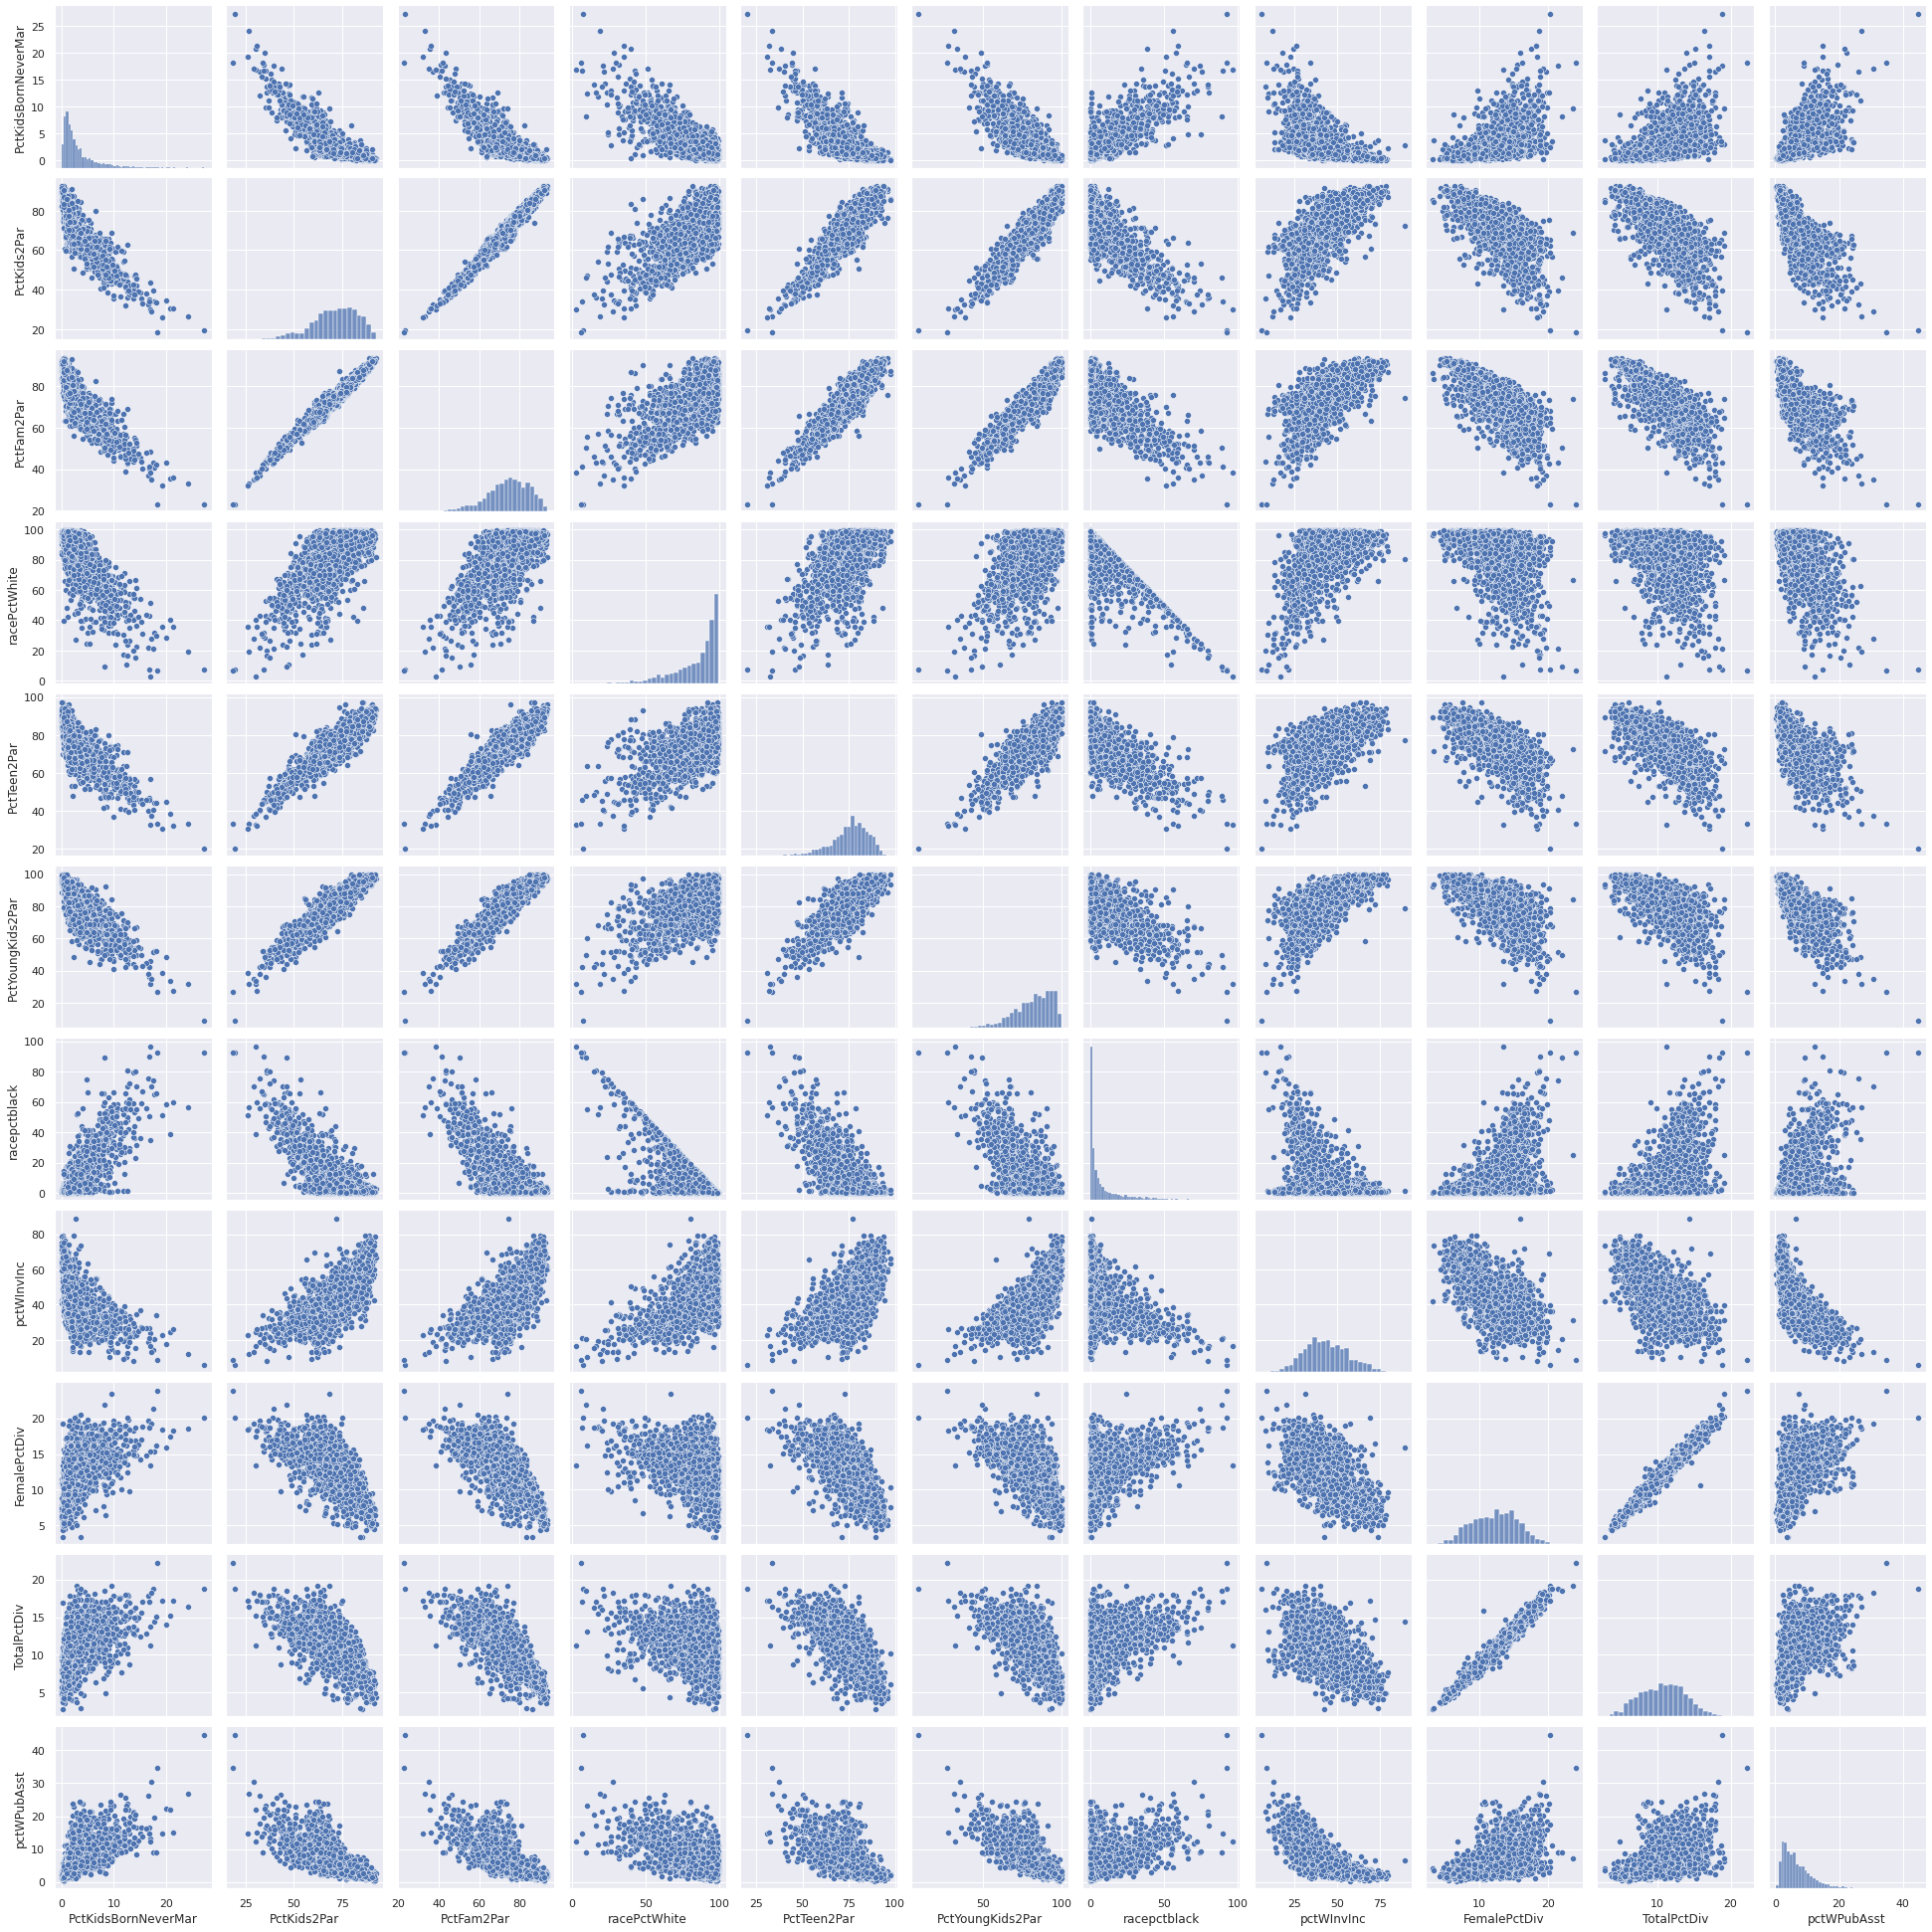

In [38]:
#Pairplots para visualizar las correlaciones 
sns.set()
cols = X.columns.values
sns.pairplot(X[cols], height = 2.5)
plt.show();

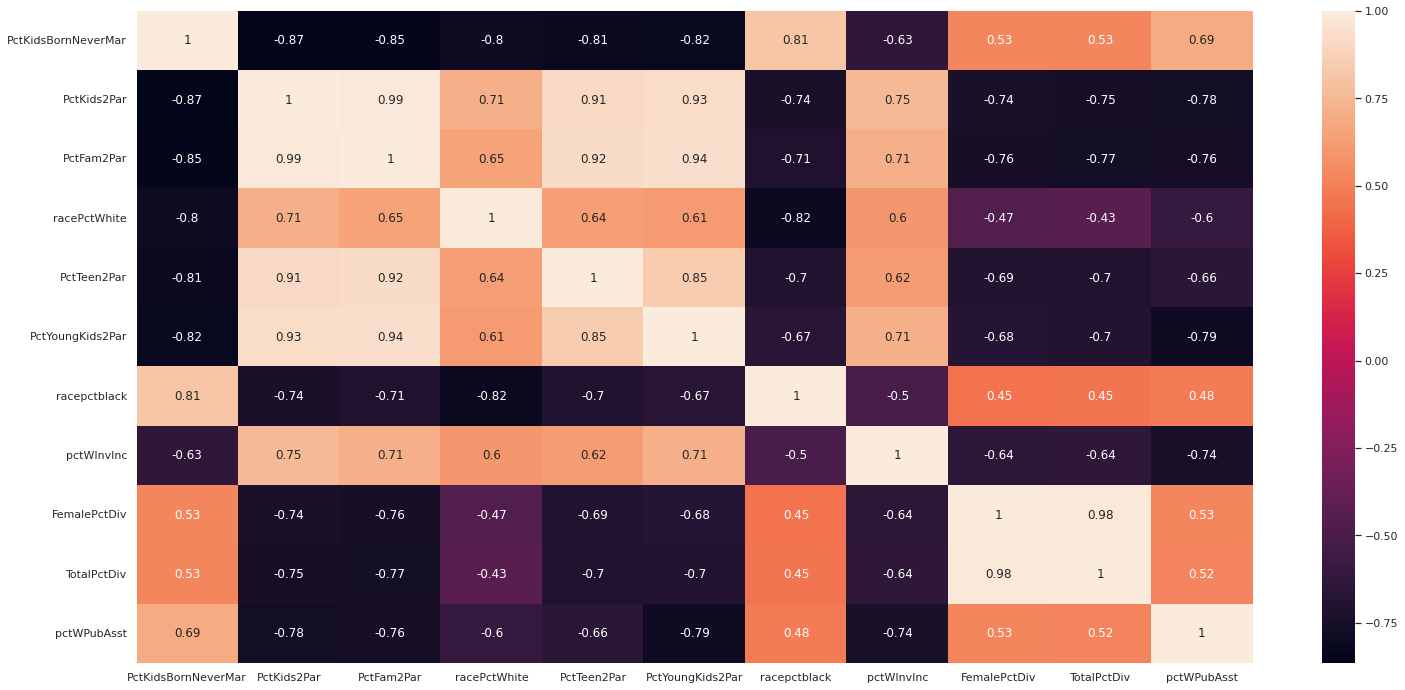

In [39]:
plt.rcParams["figure.figsize"] = (25,12)
sns.heatmap(X.corr(), annot=True)

Existen un gran número de variables que no presentan una correlación entre ellas.

# PCA

In [40]:
# Normalización df_Predictive
df_Predictive_Norm = preprocessing.MinMaxScaler().fit_transform(df_Predictive)
df_Predictive_Norm = pd.DataFrame(df_Predictive_Norm, columns=df_Predictive.columns.values)
#df_2 = df_2.reset_index(drop=True)
df_Predictive_Norm

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.000270,0.407609,0.014172,0.919030,0.112659,0.018493,0.158370,0.197284,0.106646,0.189200,0.001636,1.0000,0.577349,0.884450,0.237366,0.773639,0.262783,0.019041,0.355054,0.537776,0.421493,0.390688,0.064115,0.011927,0.255272,0.037336,0.417911,0.000108,0.023013,0.112900,0.116898,0.600258,0.046138,0.663826,0.262609,0.372916,0.096037,0.756540,0.085794,0.221878,...,0.113536,0.122576,0.479592,0.484321,0.405660,0.930621,0.005720,0.086693,0.666667,0.000162,0.989761,0.931182,0.078215,0.435135,0.416667,0.000000,0.052533,0.414227,0.505930,0.633106,0.335347,0.649667,1.000000,1.000000,0.393524,1.000000,0.440594,0.379679,0.293233,0.000470,0.000000,0.174029,0.543697,0.801139,0.730478,0.839571,0.001569,0.041518,0.177250,0.0
1,0.001794,0.331522,0.008276,0.958123,0.059377,0.007670,0.129065,0.194994,0.099017,0.303659,0.003158,1.0000,0.340287,0.726951,0.169985,0.700469,0.428751,0.057572,0.461118,0.349064,0.256798,0.232241,0.085503,0.000000,0.189083,0.038321,0.223650,0.000583,0.058229,0.108875,0.169806,0.364410,0.037111,0.620551,0.212797,0.381438,0.117016,0.532741,0.116992,0.246824,...,0.097022,0.095301,0.380952,0.425087,0.128931,0.901452,0.016151,0.222583,0.666667,0.001181,0.969933,0.854201,0.000000,0.192507,0.395833,0.012982,0.026266,0.250104,0.301144,0.363925,0.192145,0.407982,0.499432,0.598291,0.255293,0.537701,0.628713,0.358289,0.180451,0.000000,0.000000,0.134839,0.815141,0.890754,0.907197,0.943641,0.002718,0.049224,0.070679,0.0
2,0.002645,0.225543,0.007655,0.945333,0.059203,0.023432,0.136090,0.269917,0.108003,0.168656,0.004007,1.0000,0.233559,0.773202,0.176110,0.599784,0.243643,0.061828,0.263971,0.246303,0.201653,0.183518,0.078465,0.045013,0.146263,0.043460,0.153803,0.000947,0.071653,0.052324,0.105679,0.367505,0.089936,0.751546,0.289704,0.237681,0.172960,0.444520,0.444011,0.212581,...,0.059275,0.052908,0.285714,0.376307,0.160377,0.603169,0.033311,0.481144,0.666667,0.002941,0.946043,0.514002,0.023063,0.055942,0.770833,0.064908,0.022514,0.123094,0.147554,0.177617,0.112689,0.300443,0.349603,0.412698,0.186800,0.360939,0.455446,0.411765,0.112782,0.000684,0.000000,0.080040,0.440097,0.371197,0.485286,0.745788,0.002718,0.062662,0.080434,0.0
3,0.000910,0.217391,0.017586,0.976483,0.008184,0.006094,0.159976,0.258793,0.128009,0.311289,0.000000,0.0000,0.102075,0.560387,0.036753,0.398174,0.484353,0.258289,0.353627,0.124875,0.095979,0.085787,0.047068,0.010294,0.033354,0.017891,0.080351,0.001988,0.289226,0.218354,0.446260,0.118375,0.285523,0.499916,0.607962,0.347166,0.591841,0.277483,0.493036,0.249303,...,0.087585,0.069668,0.268707,0.313589,0.204403,0.531149,0.019515,0.461638,0.666667,0.003665,0.873070,0.477584,0.063675,0.692697,0.000000,0.293132,0.163227,0.044126,0.062643,0.081178,0.090937,0.106430,0.147560,0.155067,0.141968,0.174289,0.683168,0.352941,0.330827,0.000000,0.000000,0.030887,0.948721,0.672411,0.906469,0.945430,0.001205,0.072540,0.060924,0.0
4,0.000170,0.315217,0.005483,0.892006,0.019850,0.004203

In [41]:
# Algoritmo PCA
X = df_Predictive_Norm
y = df_PotentialGoal['ViolentCrimesPerPop']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=2123, test_size=0.3)

from sklearn.decomposition import PCA
pca = PCA(n_components = 23)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

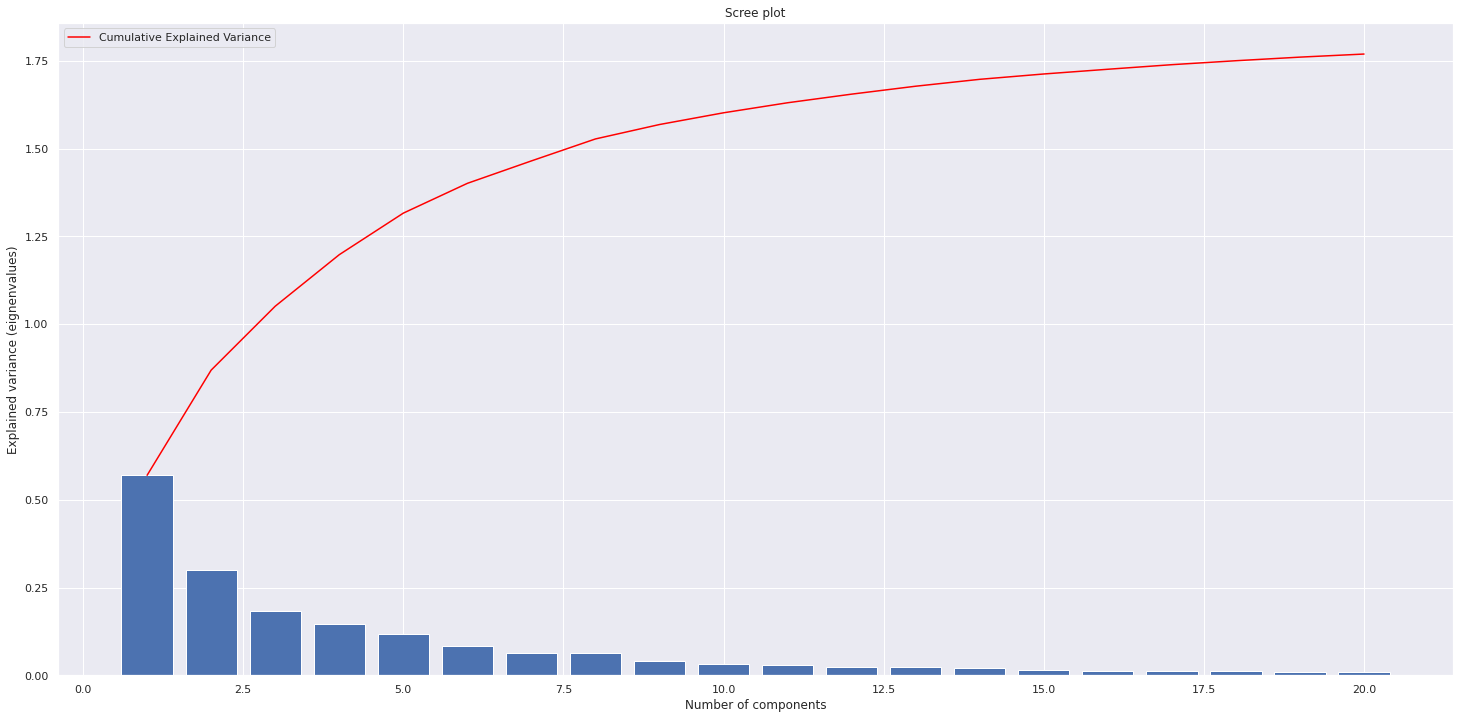

In [42]:
from sklearn.decomposition import PCA
sns.set()
 
# Reduce from 102 to 20 features with PCA
pca = PCA(n_components=20)
 
# Fit and transform data
pca.fit_transform(X_train)
 
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

Vemos que con 7 variables logramos una Varianza explicada (eignenvalues) del orden de 1.5.

# Regresión lineal con análisis de VIF

In [43]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [44]:
# features to consider removing: Se utilizan las variables obtenidas en la matriz de correlación del paso anterior para realizar este análisis
considered_features = list(df_select_corr.index)[1:]

# compute vif 
vif_df = compute_vif(considered_features).sort_values('VIF', ascending=False)
vif_df

,Variable,VIF
2,PctFam2Par,61.569939
1,PctKids2Par,59.546306
9,TotalPctDiv,41.198245
8,FemalePctDiv,39.726016
5,PctYoungKids2Par,10.891620
4,PctTeen2Par,7.239214
0,PctKidsBornNeverMar,7.157725
3,racePctWhite,5.925209
6,racepctblack,4.881256
10,pctWPubAsst,4.027772


In [45]:
len(vif_df.query('VIF<10').Variable.unique())

6

In [46]:
# features to consider removing
considered_features = vif_df.query('VIF<10').Variable.unique()

# compute vif 
vif_df = compute_vif(considered_features).sort_values('VIF', ascending=False)
vif_df

,Variable,VIF
1,PctKidsBornNeverMar,5.851810
3,racepctblack,4.447745
2,racePctWhite,4.154835
0,PctTeen2Par,3.415070
4,pctWPubAsst,2.992653
5,pctWInvInc,2.518184


In [47]:
X = df_Predictive_Norm[considered_features]
y = df_PotentialGoal['ViolentCrimesPerPop']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=32123, test_size=0.3)
X_train_lm_corr = sm.add_constant(X_train)
Model3_corr_VIF = sm.OLS(y_train, X_train_lm_corr).fit()
print(Model3_corr_VIF.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     281.1
Date:                Thu, 29 Sep 2022   Prob (F-statistic):          2.87e-243
Time:                        02:17:09   Log-Likelihood:                -11584.
No. Observations:                1550   AIC:                         2.318e+04
Df Residuals:                    1543   BIC:                         2.322e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2348.4987    195.408     12.018      0.0

El modelo con VIF no presenta una mejora importante.

# Análisis p-value

In [48]:
len(Model3_corr_VIF.pvalues[1:])

6

In [49]:
data = {'predictor': np.array(df[considered_features].columns), 'p-value': Model3_corr_VIF.pvalues[1:]}
df_pvalues = pd.DataFrame(data)
df_select_pvalue = df_pvalues.sort_values('p-value', ascending=True)
df_select_pvalue = df_select_pvalue[df_select_pvalue['p-value']<=0.05]
np.array(df_select_pvalue['predictor'])

array(['PctKidsBornNeverMar', 'racePctWhite', 'pctWInvInc', 'PctTeen2Par',
       'pctWPubAsst', 'racepctblack'], dtype=object)

In [50]:
X = df[np.array(df_select_pvalue['predictor'])]
y = df_PotentialGoal['ViolentCrimesPerPop']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=32123, test_size=0.3)
X_train_lm_pvalue = sm.add_constant(X_train)
Model4_pvalue = sm.OLS(y_train, X_train_lm_pvalue).fit()
print(Model4_pvalue.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     281.1
Date:                Thu, 29 Sep 2022   Prob (F-statistic):          2.87e-243
Time:                        02:17:09   Log-Likelihood:                -11584.
No. Observations:                1550   AIC:                         2.318e+04
Df Residuals:                    1543   BIC:                         2.322e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2647.8539    229.160     11.555      0.0

**Conclusión:**

Los modelos presentan un alcance limitado al miento de estimar la probabilidad de crímenes, se debe analizar en profundidad para hacer predicciones, un modelo de regresión no tan costoso, para el problema que intenta solucionar no es el más adecuado.